In [10]:
import dask.dataframe as dd
import numpy as np
import os
import pandas as pd

#### Thay đổi hiển thị ####
pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows')
pd.set_option('display.max_row', None)
pd.set_option('display.max_columns', None)
#### Change display ####

input_file = ["/mnt/c/Users/hoang/FileCSV_DACN_2025/parquet_shuffled_IoT23", "C:\\Users\\hoang\\FileCSV_DACN_2025\\parquet_shuffled_IoT23"]

if os.name == 'nt':
    input_file = input_file[1]
else:
    input_file = input_file[0]

df = dd.read_parquet(input_file)
# dictTypes = {}
# df = dd.read_csv(input_file)
# for col in df.columns:
#     if col.startswith('proto') == True:
#         dictTypes[col] = 'int32'
#     elif col.startswith('service_') == True:
#         dictTypes[col] = 'int32'
#     # elif col == 'label':
#     #     dictTypes[col]= 'int32'
#     elif col.startswith('detailed-label'):
#         dictTypes[col] = 'str'
#     else:
#         dictTypes[col]='float32'

# df = dd.read_csv(input_file, dtype=dictTypes) # dtype = dictTypes
df = df.drop(columns=['label'])

# phân loại đa nhãn, k dùng
# df = df.replace(r'[N|n][a|A][N|n]', 0)
# df = df.replace(np.nan, 0)
print(df.dtypes)
# print(df['duration'].value_counts().compute())
# print(df.tail())


id.orig_h         float32
id.orig_p         float32
id.resp_h         float32
id.resp_p         float32
duration          float32
orig_bytes        float32
resp_bytes        float32
conn_state        float32
missed_bytes      float32
history           float32
orig_pkts         float32
orig_ip_bytes     float32
resp_pkts         float32
resp_ip_bytes     float32
detailed-label      int32
proto_icmp          int32
proto_tcp           int32
proto_udp           int32
service_dhcp        int32
service_dns         int32
service_http        int32
service_irc         int32
service_ssh         int32
service_ssl         int32
dtype: object


In [17]:
label_counts = df['detailed-label'].value_counts().compute()

In [18]:
print((label_counts))

detailed-label
1    60938340
0    30771095
Name: count, dtype: int64


detailed-label
1    60938340
0    30771095
Name: count, dtype: int64


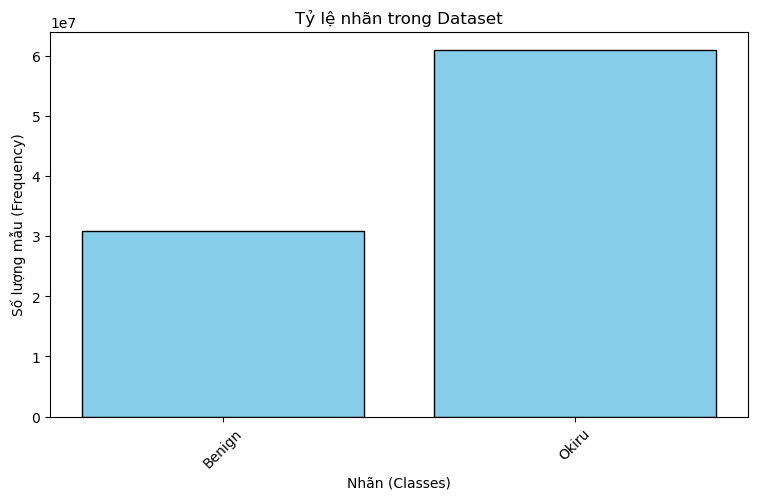

In [19]:

import matplotlib.pyplot as plt
ordered_labels = [0, 1]
ordered_counts = [label_counts.get(label, 0) for label in ordered_labels] 
print(label_counts)

labels = ["Benign", "Okiru"]
# Vẽ biểu đồ cột
plt.figure(figsize=(9, 5))
plt.bar(labels, ordered_counts, color='skyblue', edgecolor='black')
plt.xlabel("Nhãn (Classes)")
plt.ylabel("Số lượng mẫu (Frequency)")
plt.title("Tỷ lệ nhãn trong Dataset")
plt.xticks(range(len(labels)) ,labels, rotation =45)
plt.show()

In [2]:
df = df[df['detailed-label'].isin(['Okiru', 'PartOfAHorizontalPortScan', '0'])]

label_map = {
    '0': 0,
    'PartOfAHorizontalPortScan': 1,
    'Okiru': 2
}

df['detailed-label'] = df['detailed-label'].map(label_map).astype('int32')

/home/hoangvn/miniconda3/miniconda3/envs/doan/lib/python3.9/site-packages/dask_expr/_collection.py:4190: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('detailed-label', 'float64'))

  warnings.warn(meta_warning(meta))


In [2]:
print(df.dtypes)

id.orig_h         float32
id.orig_p         float32
id.resp_h         float32
id.resp_p         float32
duration          float32
orig_bytes        float32
resp_bytes        float32
conn_state        float32
missed_bytes      float32
history           float32
orig_pkts         float32
orig_ip_bytes     float32
resp_pkts         float32
resp_ip_bytes     float32
detailed-label      int32
proto_icmp          int32
proto_tcp           int32
proto_udp           int32
service_dhcp        int32
service_dns         int32
service_http        int32
service_irc         int32
service_ssh         int32
service_ssl         int32
dtype: object


# Generator + Train

In [11]:
import numpy as np
import pandas as pd
import dask.dataframe as dk
import tensorflow as tf 
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from datetime import datetime, timedelta
from tensorflow import keras

ratio_test_all = 0.2

from dask_ml.model_selection import train_test_split 
# Bước 1: Tách 80% train, 20% còn lại (val + test)
train_df, val_test_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(val_test_df, test_size=0.75, random_state=42)

2025-05-27 02:41:54.274281: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748313714.405537    1007 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748313714.445327    1007 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748313714.744198    1007 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748313714.744224    1007 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748313714.744225    1007 computation_placer.cc:177] computation placer alr

In [12]:
################################ BATCH SIZE ########################################
batchSize = 512

features_len = len(df.columns)-1
print("Feature Len: ",features_len)

def dask_to_tf_dataset(dask_df, num_classes): 
    def generator():
        for batch in dask_df.to_delayed():
            batch=batch.compute()  
            if batch.empty:
                continue

            X = batch.drop(columns='detailed-label').values.astype(np.float32)
            y = batch['detailed-label'].values.astype(np.int32)
            y_onehot = to_categorical(y, num_classes=num_classes) if num_classes >1 else y

            # for i in range(0, len(X), batchSize):
            #     yield X[i:i+batchSize], y_onehot[i:i+batchSize]
            num_splits = max(1, len(X) // batchSize)  # Đảm bảo không chia nhỏ quá mức
            X_batches = np.array_split(X, num_splits)
            y_batches = np.array_split(y_onehot, num_splits)

            for X_batch, y_batch in zip(X_batches, y_batches):
                yield X_batch, y_batch
            
    output_signature = ( 
        tf.TensorSpec(shape=(None, features_len), dtype=tf.float32), 
        tf.TensorSpec(shape=(None, num_classes), dtype=tf.int32),
    ) if num_classes>1 else ( 
        tf.TensorSpec(shape=(None, features_len), dtype=tf.float32), 
        tf.TensorSpec(shape=(None,), dtype=tf.int32),
    )
    
    return tf.data.Dataset.from_generator(generator, output_signature=output_signature).prefetch(tf.data.AUTOTUNE)

Feature Len:  23


In [13]:
############################ NUM CLASSES#########################
value_count = len(df['detailed-label'].value_counts().compute())
num_classes = 1 if  value_count<=2  else value_count


########################### GENERATOR ############################
train_gen = dask_to_tf_dataset(train_df, num_classes).repeat()
val_gen = dask_to_tf_dataset(val_df, num_classes).repeat()
test_gen = dask_to_tf_dataset(test_df, num_classes)

I0000 00:00:1748313723.973051    1007 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2248 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 with Max-Q Design, pci bus id: 0000:02:00.0, compute capability: 7.5


In [8]:
import math
n_samples = np.ceil(train_df.shape[0])
steps_per_epoch = int(n_samples / (batchSize))
validation_steps = int(steps_per_epoch / (16))
print("Steps/Epoch: ", steps_per_epoch)

Steps/Epoch:  477048


In [9]:
lr_finder = LRFinder(model)
lr_finder.find(x_train, y_train, start_lr=1e-6, end_lr=1e-2)

NameError: name 'LRFinder' is not defined

In [ ]:
########### Enable XLA ###############
tf.config.optimizer.set_jit(True)

steps_per_epoch = 477048 // 10
validation_steps= (steps_per_epoch)//16
    
########### Nếu không dùng XLA ###########
# import os
# os.environ["TF_XLA_FLAGS"] = "--tf_xla_auto_jit=0"

# shape
features, labels = next(iter(train_gen))
input_shape = (features.shape[1], 1)
output_shape = labels.shape[1] if num_classes > 1 else 1

print(f"Input Shape: {input_shape} \n Output Shape: {output_shape}")

# Định nghĩa mô hình CNN
# VGG, ...
# Conv2D, tabular, ...
# HE, tính tương thích của HE với CNN
# Tính chất data in, out; Học tăng cường
start_time = datetime.now()


loss_func = 'categorical_crossentropy' if num_classes > 1 else 'binary_crossentropy'
activation_func = 'softmax' if num_classes >1 else 'sigmoid'
print(f"Num classe: {num_classes}\nLoss Fucntion: {loss_func}\nActivation Function: {activation_func}")
model = keras.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv1D(filters=32, kernel_size=7, padding="same", activation="relu", kernel_regularizer=l2(0.05)),
    layers.BatchNormalization(),
    # layers.Conv1D(filters=128, kernel_size=3, padding="same", activation="relu"),
    # layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.7),
    layers.Flatten(), # layers.GlobalAveragePooling1D(), may be tốt hơn
    layers.Dense(64, activation='relu', kernel_regularizer=l2(0.05)),
    layers.BatchNormalization(),
    layers.Dense(1, activation= activation_func)
])
adam_optimizer = optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=adam_optimizer, loss=loss_func, metrics=['accuracy'])
model.summary()


from tensorflow.keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint
csv_logger = CSVLogger("Centralized_Log/"+ datetime.now().strftime("Month%mDay%d__%Hh%Mp")+".csv" , append=True)

model_path =  "Centralized_Model/cnn_model_" + datetime.now().strftime("Month%mDay%d__%Hh%Mp")
print("Model Path: ", model_path)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose =1),
    ModelCheckpoint(model_path+"_best.keras", monitor='val_loss', save_best_only=True, verbose=1),
    csv_logger
]
model.fit(train_gen, epochs=50,
          validation_data=val_gen, 
          validation_steps=validation_steps, 
        steps_per_epoch=steps_per_epoch, verbose = 1, callbacks=callbacks)

end_time = datetime.now()
simulated_time = end_time - start_time

# Lưu mô hình
model.save(model_path+".keras")

print(f"Simulated time: {simulated_time}")

Input Shape: (23, 1) 
 Output Shape: 1
Num classe: 1
Loss Fucntion: binary_crossentropy
Activation Function: sigmoid


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 23, 32)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 23, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 11, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 11, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 352)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        22,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,297 (91.00 KB)

 Trainable params: 23,105 (90.25 KB)

 Non-trainable params: 192 (768.00 B)

Model Path:  Centralized_Model/cnn_model_Month05Day27__02h42p
Epoch 1/50


I0000 00:00:1748313727.902620    2025 service.cc:152] XLA service 0x7fe834005250 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748313727.902657    2025 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 with Max-Q Design, Compute Capability 7.5
I0000 00:00:1748313727.924152    2025 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1748313728.051233    2025 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-05-27 02:42:08.912020: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


47696/47704 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5360 - loss: 5.0533
Epoch 1: val_loss improved from inf to 1.97686, saving model to Centralized_Model/cnn_model_Month05Day27__02h42p_best.keras
47704/47704 ━━━━━━━━━━━━━━━━━━━━ 254s 5ms/step - accuracy: 0.5360 - loss: 5.0531 - val_accuracy: 0.8630 - val_loss: 1.9769
Epoch 2/50
47701/47704 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7382 - loss: 1.6142
Epoch 2: val_loss improved from 1.97686 to 0.46487, saving model to Centralized_Model/cnn_model_Month05Day27__02h42p_best.keras
47704/47704 ━━━━━━━━━━━━━━━━━━━━ 234s 5ms/step - accuracy: 0.7382 - loss: 1.6142 - val_accuracy: 0.9823 - val_loss: 0.4649
Epoch 3/50
47696/47704 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8421 - loss: 0.6082
Epoch 3: val_loss improved from 0.46487 to 0.22105, saving model to Centralized_Model/cnn_model_Month05Day27__02h42p_best.keras
47704/47704 ━━━━━━━━━━━━━━━━━━━━ 240s 5ms/step - accuracy: 0.8421 - loss: 0.6082 - val_accuracy: 0.9828 - val_loss:

# Pre, Re, F1

Precision:  0.9997366418914965
Recall:  0.9999414639857173
F1-Score:  0.999839042448896


2025-05-27 07:59:55.997550: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


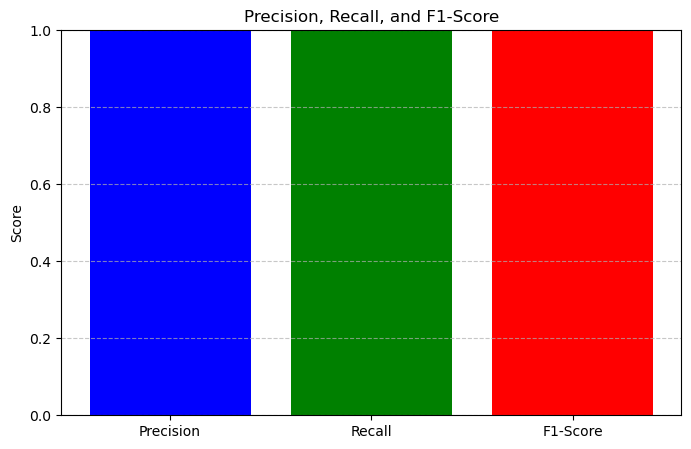

In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

model_path = "Centralized_Model/cnn_model_Month05Day27__02h42p_best.keras"
model = load_model(model_path)
#model = load_model("saved_model/cnn_model_2-0_batch512_20h37p__06-05-2025.keras")
# Tính số hàng thật sự trong test_df
num_batches_test = 100
y_true_all = []
y_pred_all = []

for X_batch, y_batch in test_gen.take(num_batches_test):
    y_true_all.extend(y_batch.numpy().flatten())

    y_pred_prob = model.predict(X_batch, verbose=0)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    y_pred_all.extend(y_pred)

# Tính metric
precision = precision_score(y_true_all, y_pred_all, average='binary')
recall = recall_score(y_true_all, y_pred_all, average='binary')
f1 = f1_score(y_true_all, y_pred_all, average='binary')

print("Precision: ", precision)
print("Recall: ", recall)
print("F1-Score: ", f1)

param_names = ['Precision', 'Recall', 'F1-Score']
array = [precision, recall, f1]

x = np.arange(len(param_names))
width = 0.2  # Độ rộng của mỗi cột
plt.figure(figsize=(8, 5))
plt.bar(param_names, array, color=['blue', 'green', 'red'])

# Cấu hình trục và nhãn
plt.ylabel("Score")
plt.title("Precision, Recall, and F1-Score")
plt.ylim(0, 1)  # Giá trị từ 0 đến 1
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Hiển thị biểu đồ
plt.show()


# Confusion matrix

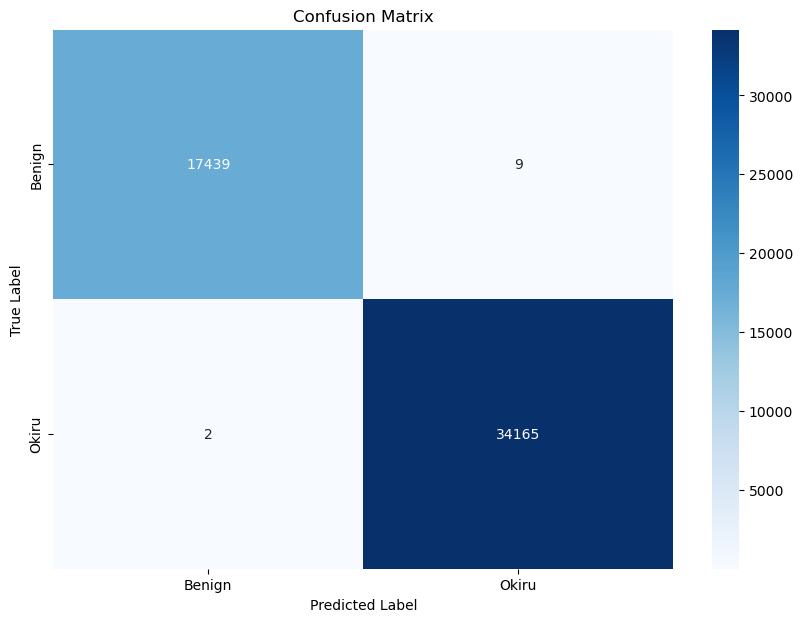

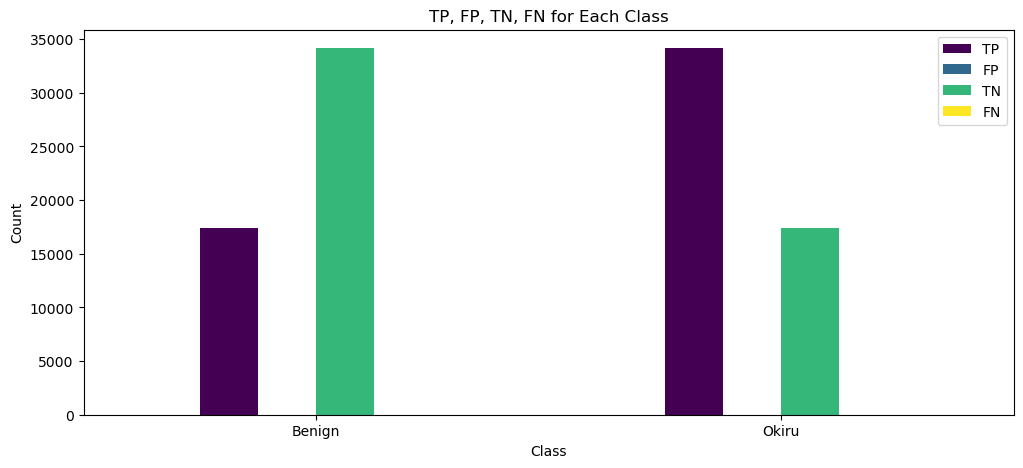

: 

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Tạo ma trận nhầm lẫn
cm = confusion_matrix(y_true_all, y_pred_all)

attack_types =['Benign', 'Okiru']
# Vẽ heatmap
plt.figure(figsize=(10, 7))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(cm.shape[0]), yticklabels=range(cm.shape[0))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=attack_types, yticklabels=attack_types)

# Thêm nhãn
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

# Hiển thị
plt.show()


metrics = []
num_classes = len(attack_types)

# Duyệt từng lớp để tính TP, FP, TN, FN
for i in range(num_classes):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    
    metrics.append([attack_types[i], TP, FP, TN, FN])

# Chuyển thành DataFrame
df_metrics = pd.DataFrame(metrics, columns=["Attack_Types", "TP", "FP", "TN", "FN"])
# Vẽ biểu đồ
df_metrics.set_index("Attack_Types").plot(kind="bar", figsize=(12, 5), colormap="viridis")

# Thêm nhãn
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("TP, FP, TN, FN for Each Class")
plt.xticks(rotation=0)
plt.legend(["TP", "FP", "TN", "FN"])

# Hiển thị
plt.show()

# Acc, Loss Graph

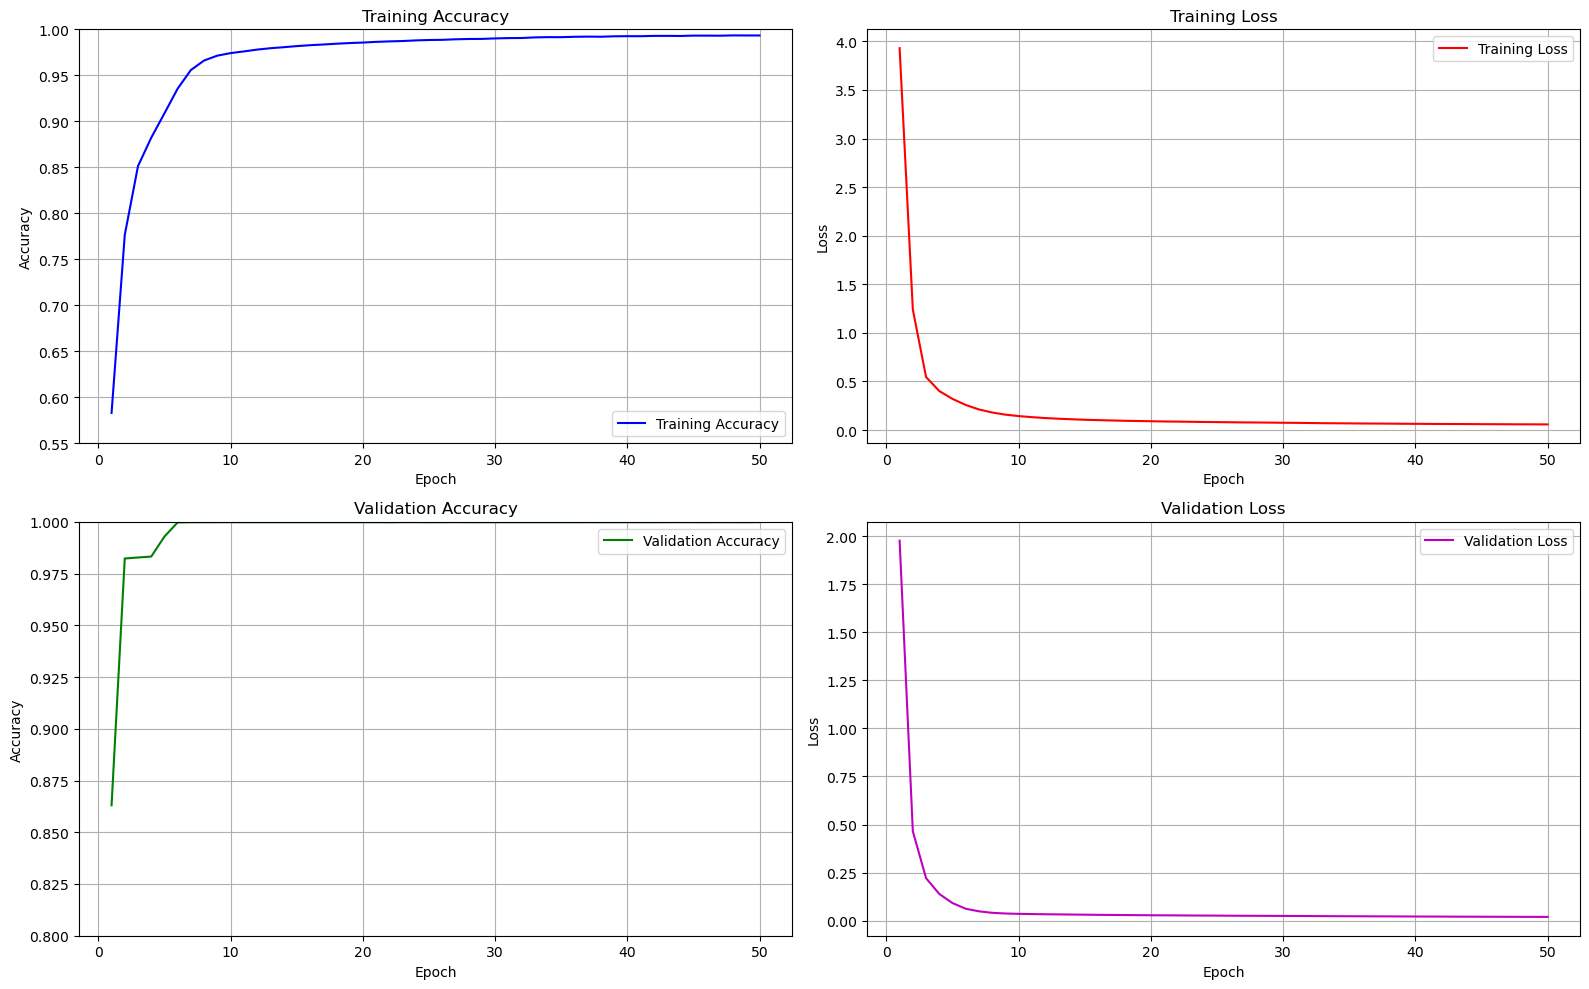

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Đọc log từ file CSV
log_name = "/mnt/c/Users/hoang/D/Code/CoCheMalware/Centralized_Log/Month05Day27__02h42p.csv"
log_df = pd.read_csv(log_name)  # Đổi tên file nếu cần

epochs = range(1, 51)#len(log_df) + 1

plt.figure(figsize=(16, 10))

# Accuracy
plt.subplot(2, 2, 1)
plt.plot(epochs, log_df['accuracy'], 'b-', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.ylim(0.55, 1.0)

# Loss
plt.subplot(2, 2, 2)
plt.plot(epochs, log_df['loss'], 'r-', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Validation Accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, log_df['val_accuracy'], 'g-', label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.ylim(0.8, 1.0)

# Validation Loss
plt.subplot(2, 2, 4)
plt.plot(epochs, log_df['val_loss'], 'm-', label='Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()